## Import packages

In [18]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison


## Load data

In [6]:
apps = pd.read_csv("googleplaystore.csv")

## Question setup

In [3]:
# Is there a difference in the number of reviews among the three app categories of beauty, food and drink,
# and photography? 

# In order to answer this question, your x, or independent variable, will be the app categories, 
# which has three levels: beauty, food and drink, and photography. Your y, or dependent variable, 
# will be the reviews. As with all ANOVAs, the IV will be categorical, and the DV will be continuous.

## Data Wrangling

In [4]:
# Although you can run the actual ANOVA using the original data, you can't test the assumptions or run the post 
# hocs unless the data is wrangled.



### Focusing on the Three Categories
 

In [7]:
# The data has many more categories than three, so you will need to filter the dataset by the categories 
# you want: beauty, food and drink, and photography.

categories = ['BEAUTY', 'FOOD_AND_DRINK','PHOTOGRAPHY']
apps1 = apps['Category'].isin(categories)
apps2 = apps[apps1].copy()

In [8]:
# The code above makes a list of the categories you want to keep, then searches through the Category column 
# using the isin() function to keep only those that match. Then, you can apply that list to your actually data
# frame, being sure to you use the .copy() function to change this from a slice into a data frame.

### Subsetting to Only the Variables Needed


In [9]:
# You only want to keep the two variables you'll need in your test: Category and Reviews.

apps3 = apps2[['Category','Reviews']]

### Changing the DV, Reviews, to integer

In [10]:
# Your dependent variable will need to be an integer. You can check what format it is in by using the .info() function:

apps3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515 entries, 98 to 10740
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  515 non-null    object
 1   Reviews   515 non-null    object
dtypes: object(2)
memory usage: 12.1+ KB


In [11]:
apps3.Reviews = apps3.Reviews.astype(int)


/var/folders/w0/t7zkm9d12h11l_wy7wwcclsm0000gn/T/ipykernel_15591/1715174673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apps3.Reviews = apps3.Reviews.astype(int)


### Recoding Category to Number too

In [12]:
# The post-hocs and assumptions won't take any string values, so you'll need to recode Category as well:

def recode (series):
    if series == "BEAUTY": 
        return 0
    if series == "FOOD_AND_DRINK": 
        return 1
    if series == "PHOTOGRAPHY": 
        return 2

apps3['CategoryR'] = apps3['Category'].apply(recode)


/var/folders/w0/t7zkm9d12h11l_wy7wwcclsm0000gn/T/ipykernel_15591/3882659166.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apps3['CategoryR'] = apps3['Category'].apply(recode)


In [13]:
apps3.head()

,Category,Reviews,CategoryR
98,BEAUTY,18900,0
99,BEAUTY,49790,0
100,BEAUTY,1150,0
101,BEAUTY,1739,0
102,BEAUTY,32090,0


### Dropping the original Category Variable

In [14]:
# You now have three variables again! Go ahead and drop the original Category variable out, 
# since it's mere presence will throw off the work you'll do later.

apps4 = apps3[['CategoryR','Reviews']]

In [15]:
# And finally, eons later, you are all prepared to run a one-way ANOVA and all it's assumptions and post-hoc tests.
# Phew! R required a lot less wrangling, because it is specifically meant for advanced statistics.



## Running the assumptions

In [16]:
# If the assumptions are not met for ANOVA, but you proceeded anyway, you run the risk of biasing your results.

### Normality

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Reviews', ylabel='Density'>

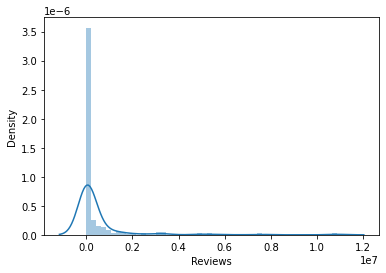

In [21]:
# You only need to test for the normality of the dependent variable, since the IV is categorical.

sns.distplot(apps4['Reviews'])

In [22]:
# sns.displot(data = apps4, x = 'Reviews', kde = True)

In [23]:
# Looks like that isn't normal in any way - it is very highly positively skewed. So, you'll need to transform price by taking the square root or the log.

apps4['ReviewsSQRT'] = np.sqrt(apps4['Reviews'])

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ReviewsSQRT', ylabel='Density'>

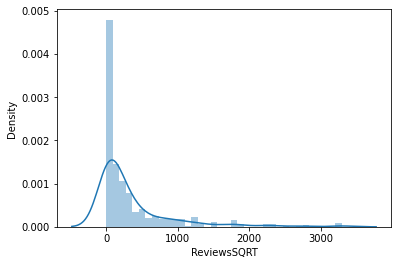

In [24]:
# Plotting

sns.distplot(apps4['ReviewsSQRT'])

In [25]:
# That looks relatively normal, so keep it there:

## Homogeneity of Variance

In [27]:
# Just like in R, you can test for homogeneity of variance easily using either Bartlett's test or Fligner's Test. Bartlett's test is for when your data is normally distributed, and Fligner's test is for when your data is non-parametric. No matter which test you are using, you are looking for a non-significant test. The null hypothesis for both of these is that the data has equal variance, so you'd like to have a p value of > .05. Since you have corrected your data, you can use Bartlett's test, but just for learning purposes, you'll try both here.

### Bartlett's Test


In [28]:
# To do Bartlett's test, use the function scipy.stats.bartlett(), with the argument of the y data,
# followed by the x data.

scipy.stats.bartlett(apps4['ReviewsSQRT'], apps4['CategoryR'])


BartlettResult(statistic=6187.981817647615, pvalue=0.0)

In [29]:
# The p value associated with this test is < .05, which means that unfortunately, you have violated the assumption
# of homogeneity of variance.

### Fligner's Test


In [30]:
# To perform Fligner's test, use the function scipy.stats.fligner(), with the argument of the y data, followed by the x data.

scipy.stats.fligner(apps4['ReviewsSQRT'], apps4['CategoryR'])

FlignerResult(statistic=642.0602581715318, pvalue=1.1908711834100128e-141)

In [31]:
# The p value is still < .05, which means you have violated the assumption of homogeneity of variance.

### Correcting for Violations of Homogeneity of Variance


In [32]:
# As you know, there are many different ways to correct for this violation in the general field of statistics. 
# However, Python does not support any of them! Which means that you can run the ANOVA, but there is a good 
# chance it will be inaccurate. If you do choose to proceed with the analysis in Python, ensure that all
# parties consuming your results understand that there could be inaccuracies with the data analysis!

# It is recommended, however, that if you violate the assumption of homogeneity of variance that you switch over
# to R, and proceed from there. You are becoming a guru in both languages for a reason!

### Sample Size

In [33]:
# An ANOVA requires a sample size of at least 20 per independent variable. In this case, you only have one 
# independent variable, so as long as you have at least 20 cases, you are fine. Looking at the data, the n is 515, 
# so you are fine to proceed with this assumption!

### Independence

In [35]:
### There is no statistical test for the assumption of independence, so you can proceed!



## Computing ANOVAs with Equal Variance (Met Homogeneity of Variance Assumption)


In [36]:
# In this case, your data did not meet this assumption, but for the purposes of learning, you'll be 
# shown what to do if you had.

# Below is the code to run a one-way ANOVA in Python. It uses the function stats.f_oneway() and the arguments
# are the three categories, crossed with your dependent variable. So here your DV is listed out, followed by the 
# first level of your IV. Each level is separated by a comma:

In [37]:
stats.f_oneway(apps['Reviews'][apps['Category']=='BEAUTY'],
                    apps['Reviews'][apps['Category']=='FOOD_AND_DRINK'],
                    apps['Reviews'][apps['Category']=='PHOTOGRAPHY'])


F_onewayResult(statistic=11.467490725511773, pvalue=1.342932747373518e-05)

In [38]:
# Since the p value is less than .05, there is a significant difference in Reviews between these three categories.



## Computing ANOVAs with Unequal Variance (Violated Homogeneity of Variance Assumption)

In [39]:
# There is NO WAY to compute ANOVAs with unequal variance in Python! Either switch over to R or be 
# VERY CAUTIOUS when interpreting your results and don't use for anything high stakes!



## Post Hocs

In [40]:
# It's important to run post-hocs to figure out what groups significantly differed from each other.
# In Python, the only automatically coding for post-hocs that is available is the Tukey post hoc, 
# so that is what you will learn.



### Computing Post Hocs with Tukey's


In [41]:
# Here is the code for computing a Tukey's post hoc in Python:

postHoc = MultiComparison(apps4['ReviewsSQRT'], apps4['CategoryR'])
postHocResults = postHoc.tukeyhsd()
print(postHocResults)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     0      1   111.89 0.4062 -93.3095 317.0896  False
     0      2  419.474    0.0 233.9776 604.9704   True
     1      2  307.584    0.0 176.8235 438.3446   True
------------------------------------------------------


In [42]:
# Interpreting this is a little harder than in R, because you've been forced to recode your categorical IV to have
 # numbers instead. So, make sure you refer back to that recode command to remember which number is which. 
    # 0 stands for beauty apps, 1 stands for food and drink apps, and 2 stands for photography apps. 
    # This output provides you with the mean difference in the number of reviews per comparison, plus the
    # confidence interval (lower and upper columns), and whether or not you can reject the null hypothesis. 
    # If the value in the reject column is True, then this means there was a significant difference in the means
    # between those groups. So, there is a significant difference between the number of reviews between 
# photography and both beauty and food and drink apps. What is that difference? Well, you will have to examine
# the means.



### Computing Post Hocs When You've Violated the Assumption of Homogeneity of Variance

In [43]:
# There is NO WAY to compute post hocs with unequal variance in Python! Either switch over to R or be VERY CAUTIOUS when interpreting your results and don't use for anything high stakes!



## Determine Means and Draw Conclusions


In [44]:
# The last step is just to examine the means, to determine which apps had the highest and lowest number of reviews.

apps4.groupby('CategoryR').mean()


,Reviews,ReviewsSQRT
CategoryR,,
0,7476.226415,48.854024
1,69947.480315,160.744038
2,637363.134328,468.328067


In [45]:
# Looking at the reviews column, which has the means, you can say that photography apps had significantly more reviews than both beauty and food and drink apps.
